In [8]:
import os
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

from src.train.rldataset import MsgVecDataset
from src.config import HOST_CONFIG, MODEL_CONFIGS

brain_config = MODEL_CONFIGS["basic-brain-test1"]
cache = MsgVecDataset(os.path.join(HOST_CONFIG.RECORD_DIR), brain_config)

groups = cache.lh.group_logs()
print(f"Found {len(groups)} groups")

#group = next(g for g in groups if g[0].get_runname() == "alphalog-5ef54ef2")
group = next(g for g in groups if g[0].get_runname() == "alphalog-4425c446")

print(f"Group {group[0].get_runname()} has {len(group)} logs")

samples = list(cache.generate_log_group(group, shuffle_within_group=False))

print(f"Num samples in group: {len(samples)}")


Found 52 groups
Group alphalog-4425c446 has 8 logs
Num samples in group: 1681


{'obs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'reward': 0.019260942935943604, 'reward_override': False, 'key': 'alphalog-4425c446-42', 'done': False, 'act': array([ 0.        ,  0.        , -0.16604072,  0.27990437], dtype=float32), 'next_obs': array([0.        , 0.        , 0.        , ..., 0.25553608, 0.28219414,
       0.2920401 ], dtype=float32)}


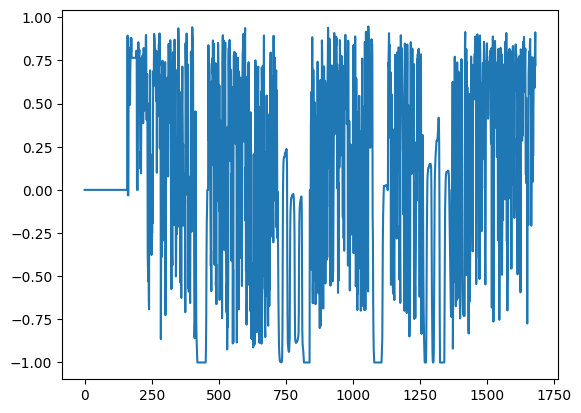

In [9]:

# Plot an action from each sample
print(samples[0])
plt.plot([s["act"][0] for s in samples])


<BarContainer object of 100 artists>

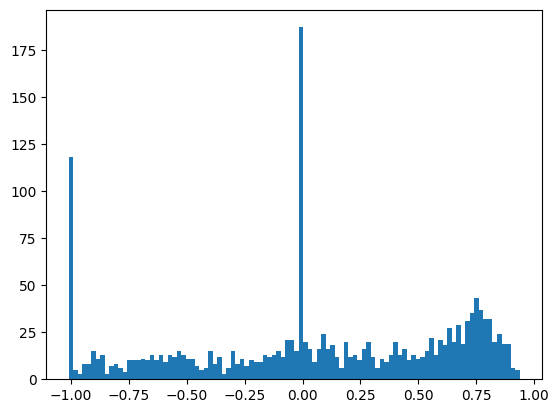

In [10]:
# Plot histogram of an action from each sample
counts, bins = np.histogram([s["act"][0] for s in samples], bins=100)

plt.bar(bins[:-1], counts, width=np.diff(bins))

In [11]:
# Get an instance of the brain model, and see the actions when you feed in slightly perturbed observations
import onnxruntime
from src.train.modelloader import create_and_validate_onnx
onnx_path = create_and_validate_onnx(brain_config)

sess = onnxruntime.InferenceSession(onnx_path)

index = 400

sample_orig = np.copy(samples[index]["obs"])
sample_mod = np.copy(samples[index + 4]["obs"])
print(sample_orig.shape)

# Add random noise to sample_mod
#sample_mod += np.random.normal(0, 0.2, sample_mod.shape)

orig_outputs = sess.run(["action"], {"observation": sample_orig.reshape(1, -1)})
mod_outputs = sess.run(["action"], {"observation": sample_mod.reshape(1, -1)})

print("Orig", orig_outputs[0])
print("Index + 4", mod_outputs[0])

Found cached ONNX model /media/storage/robotaicache/models/basic-brain-test1-sb3-run24-bf8d2a80f6af6174_orig.onnx
PT-ONNX Output 0 matches: 100.000%
(34211,)
Orig [[-0.14231066  0.22591554 -0.8468559  -0.583947  ]]
Index + 4 [[ 0.67927724  0.4673478  -0.8212357  -0.84339756]]


In [12]:
# Recalculate all of the actions for the group
actions = []
for sample in samples:
    outputs = sess.run(["action"], {"observation": sample["obs"].reshape(1, -1)})
    actions.append(outputs[0][0])

-0.941016 0.9714241


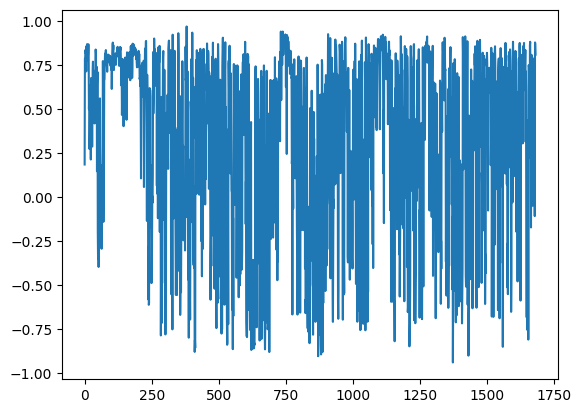

In [13]:
# Now, show the histogram of the actions again
counts, bins = np.histogram([a[3] for a in actions], bins=100)

print(min([a[0] for a in actions]), max([a[0] for a in actions]))


plt.plot([a[0] for a in actions])
#plt.bar(bins[:-1], counts, width=np.diff(bins))

[ 0.49010465  0.21768174 -0.77604496 -0.7523825 ]
[ 0.8011904  0.5068008 -0.7905362 -0.8830363]

[ 0.9363836   0.7943195  -0.84813726 -0.94278926]
[ 0.94196534  0.8010098  -0.8291794  -0.947166  ]


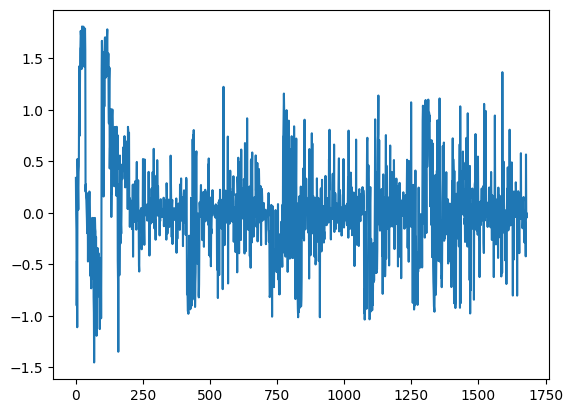

In [14]:
print(actions[396])
print(samples[396]["act"])
print()
print(actions[401])
print(samples[401]["act"])

# Plot difference of sample and actions
plt.plot([a[3] - s["act"][3] for a, s in zip(actions, samples)])

In [15]:
# Load the pytorch version of the model
import torch
from src.train.modelloader import create_pt_model

full_model = SAC.load(brain_config["checkpoint"])

inp = torch.from_numpy(samples[396]["obs"].reshape(1, -1)).to("cuda")
full_model.actor(inp, deterministic=False)

NameError: name 'SAC' is not defined

In [ ]:
# Check how much variance there is in the critic
full_model.critic(inp, full_model.actor(inp, deterministic=False))

AttributeError: 'OnnxableActor' object has no attribute 'critic'